<a href="https://colab.research.google.com/github/fralfaro/MAT306/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT306 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [25]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [26]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [27]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT306/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [28]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



Veamos las series de tiempo calculadas anteriormente.

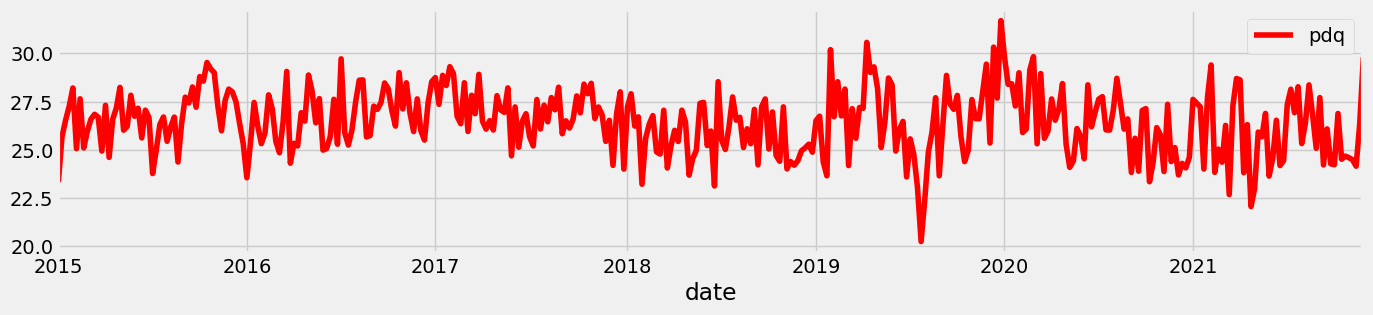

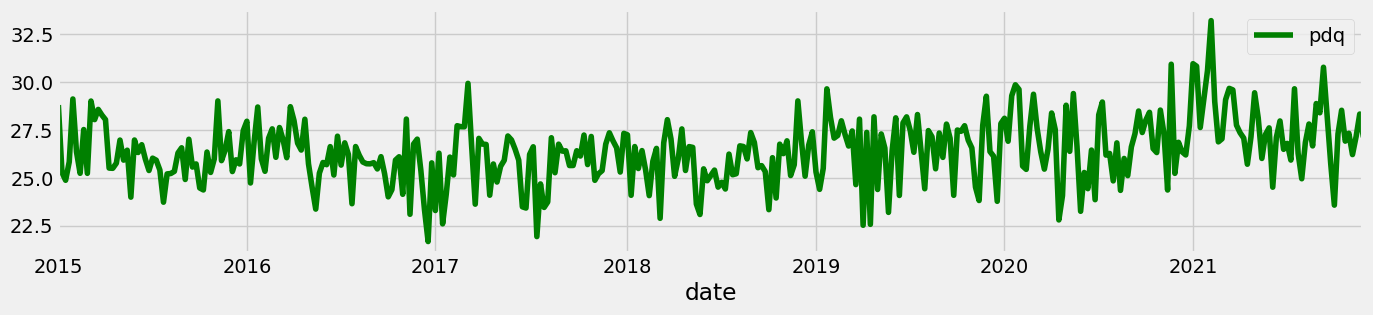

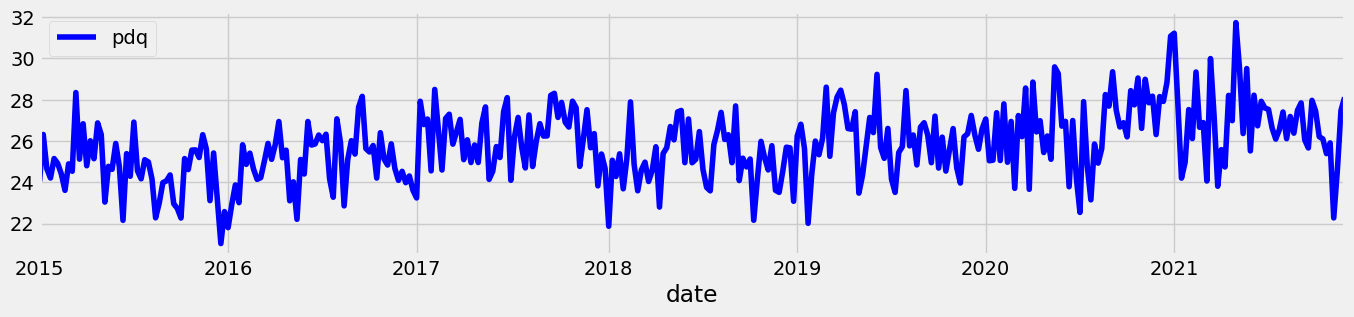

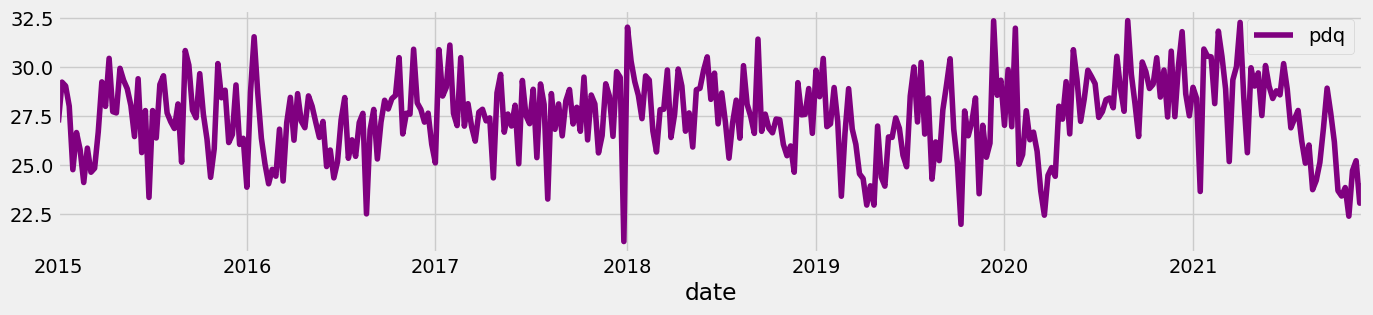

In [29]:
y_s1.plot(figsize=(15, 3),color = 'red')
y_s2.plot(figsize=(15, 3),color = 'green')
y_s3.plot(figsize=(15, 3),color = 'blue')
y_s4.plot(figsize=(15, 3),color = 'purple')
plt.show()

No se evidencian patrones inmediatamente en las series temporales individualmente ni en relación entre ellas. Hagamos una descomposición STL de las series temporales dadas.

In [30]:
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 18, 8
decomposition_s1 = sm.tsa.seasonal_decompose(y_s1, model='multiplicative')
decomposition_s2 = sm.tsa.seasonal_decompose(y_s2, model='multiplicative')
decomposition_s3 = sm.tsa.seasonal_decompose(y_s3, model='multiplicative')
decomposition_s4 = sm.tsa.seasonal_decompose(y_s4, model='multiplicative')

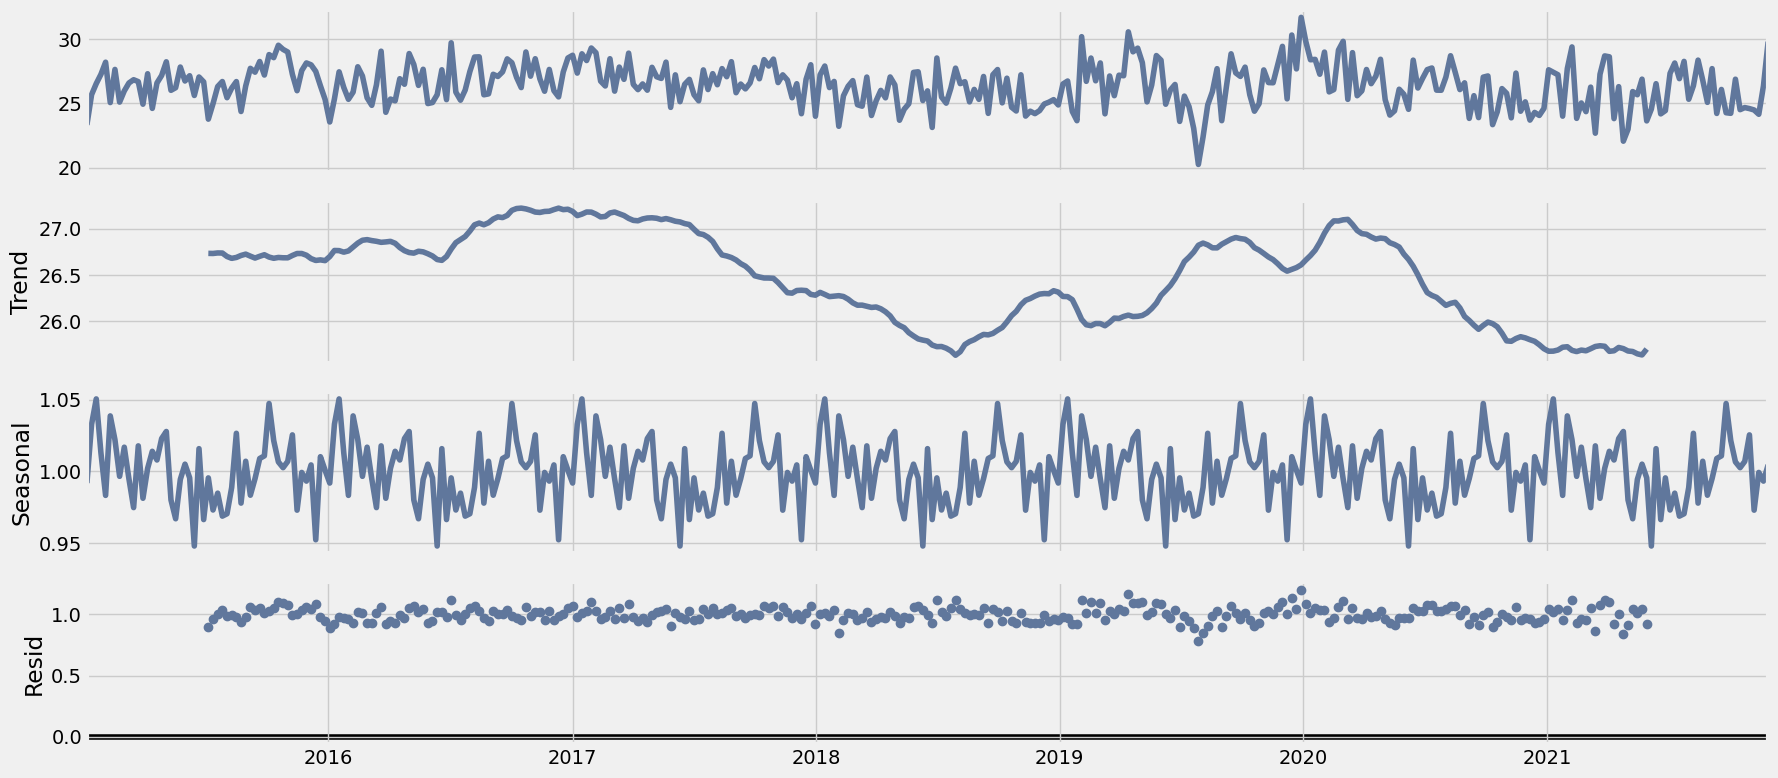

In [31]:
fig=decomposition_s1.plot()
plt.show()

Esta serie temporal corresponde a **Introduction: breaking and entering into a public establishment or private residence, theft of a firearm from a residence**. La tendencia parece oscilar un poco entre las fechas pedidas, terminando más baja que en el inicio. La estacionalidad muestra que a mediados del año es una temporada baja para este tipo de crimen, mientras que a fines y a inicios de cada año parece ser la temporada alta. El residuo es relativamente constante  cercano a 1 a lo largo del tiempo.

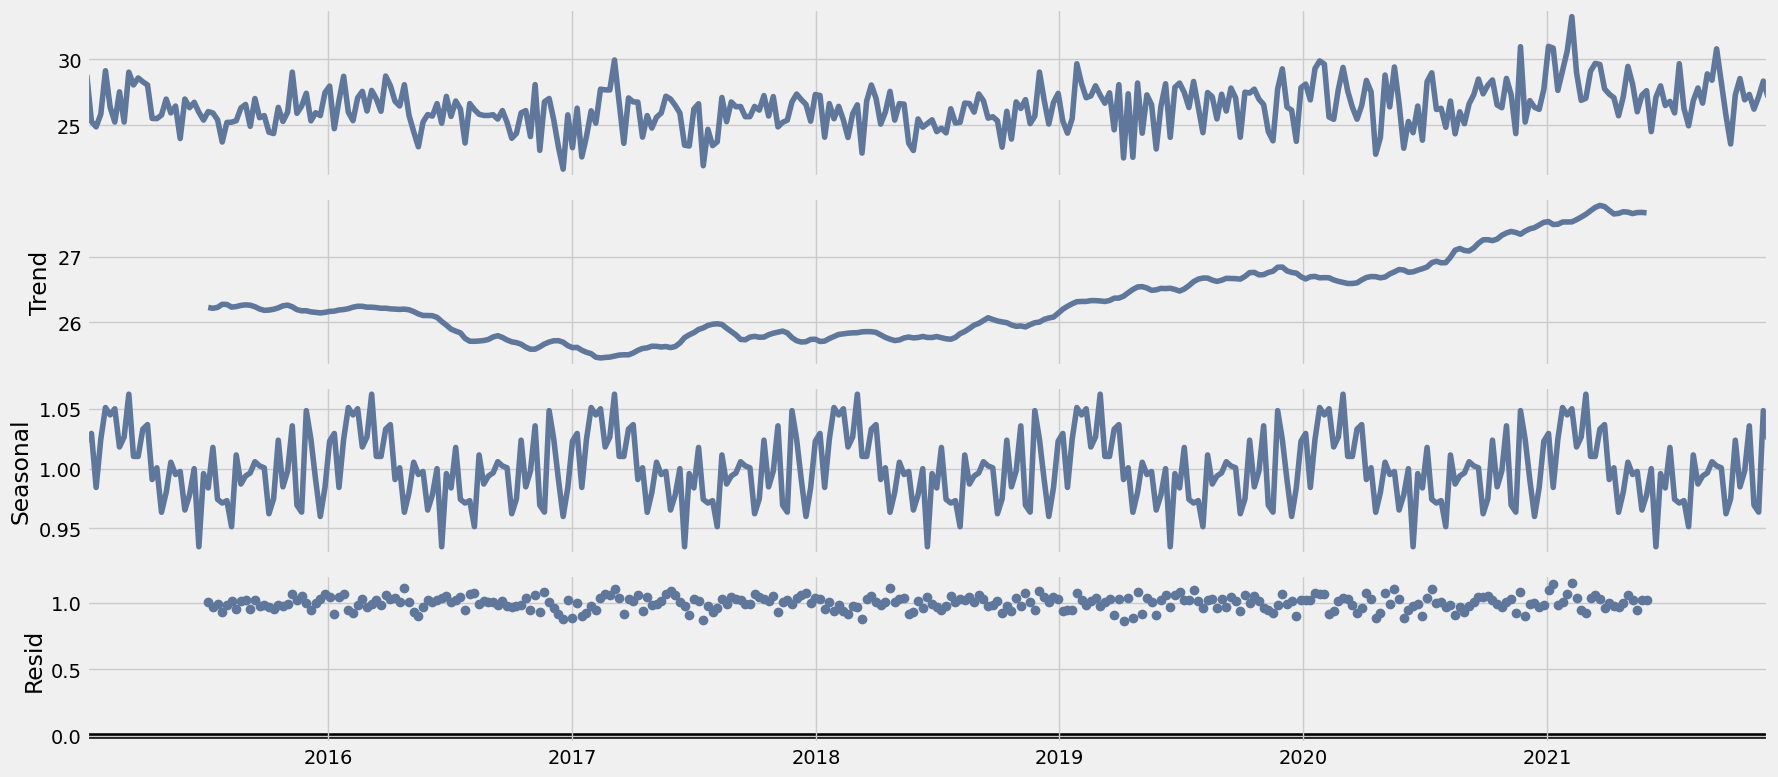

In [32]:
fig=decomposition_s2.plot()
plt.show()

Esta serie temporal corresponde a **Méfait: Graffiti and damage to religious property, vehicles or general damage and all other types of misdeeds**. La tendencia se puede ver que ha crecido ligeramente a lo largo del tiempo. La estacionalidad es similar a la del ejemplo anterior pero más pronunciada. El residuo sigue siendo constante y cercano a 1 en este modelo multiplicativo.

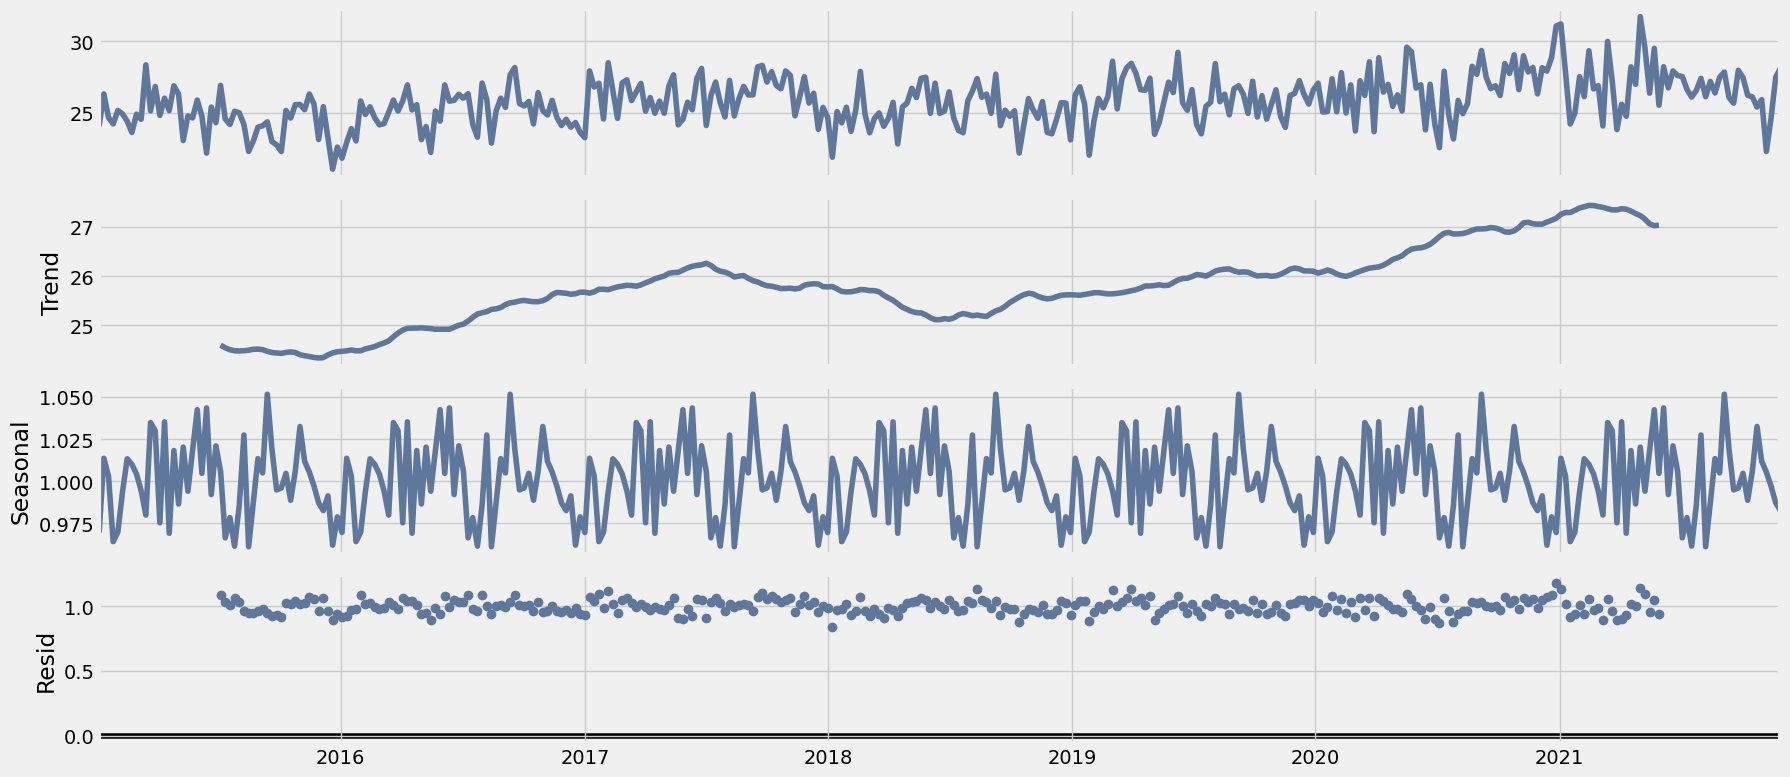

In [33]:
fig=decomposition_s3.plot()
plt.show()

Esta serie temporal corresponde a **Vol dans / sur véhicule à moteur: theft of the contents of a motor vehicle (car, truck, motorcycle, etc.) or of a vehicle part (wheel, bumper, etc.)**. La tendencia parece aumentar en el tiempo más que las anteriores series temporales. La estacionalidad no posee un patrón muy claro, salvo que parece disminuir a inicios y fines de cada año ligeramente. El residuo sigue siendo constante cercano a 1.

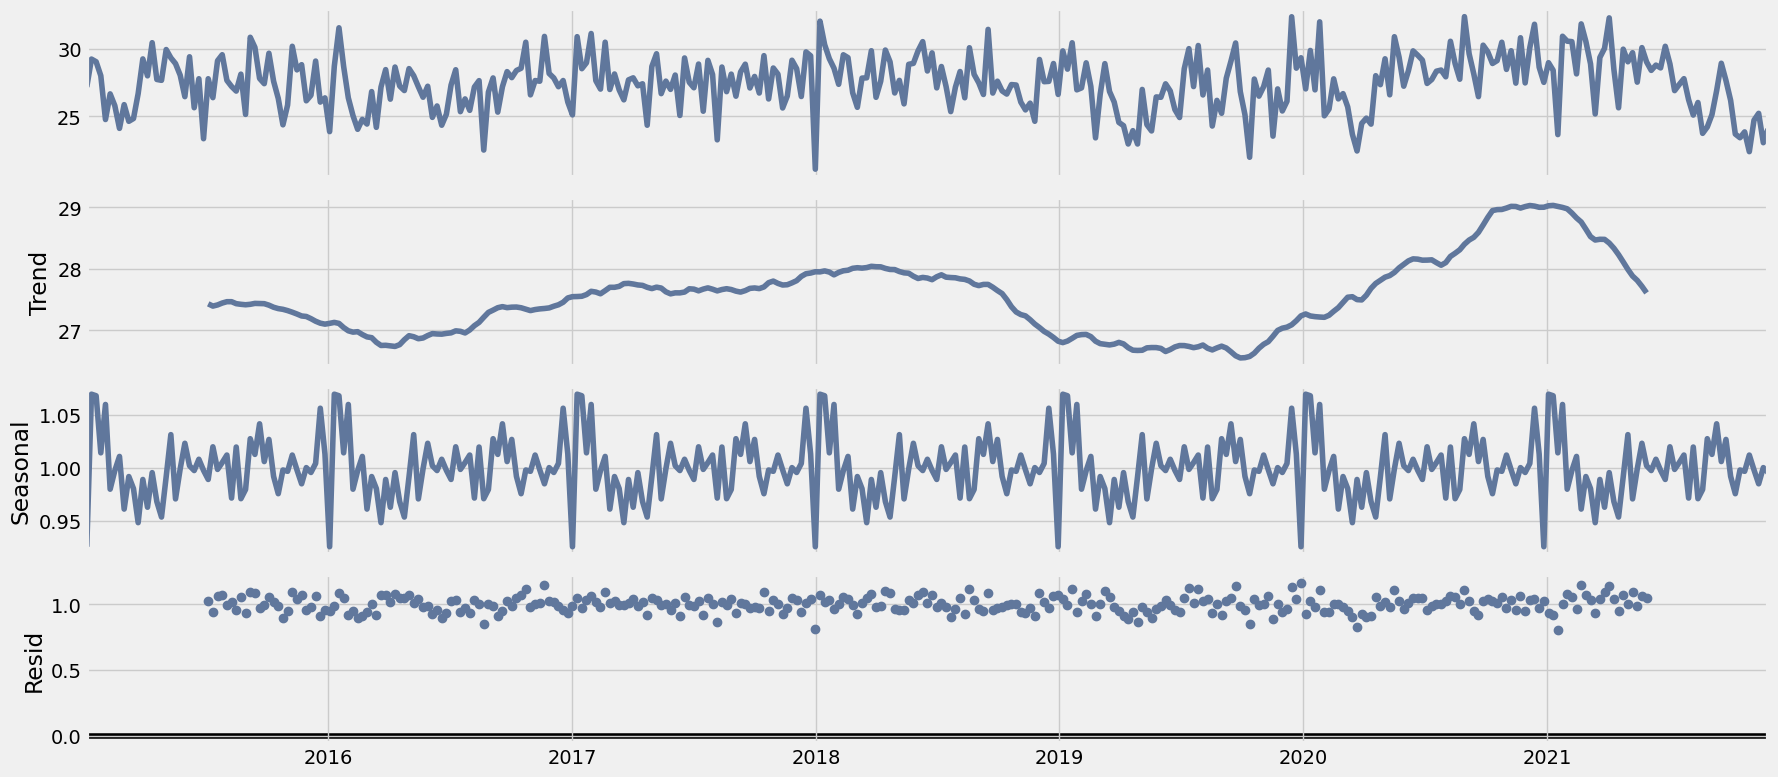

In [34]:
fig=decomposition_s4.plot()
plt.show()

Esta serie temporal corresponde a **Vol de véhicule à moteur: theft of car, truck, motorcycle, snowmobile, tractor with or without trailer, construction or farm vehicle, off-road vehicle**. La tendencia parece oscilar un poco durante el tiempo, y termina cercano al valor como inició. La estacionalidad y residuo parecen similares a la primera serie temporal analizada.



2. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



Escogamos la primera serie temporal $y_{s1}$. Ya vimos posibles tendencias y patrones en la parte anterior. Ahora hagamos los gráficos ACF y PACF.

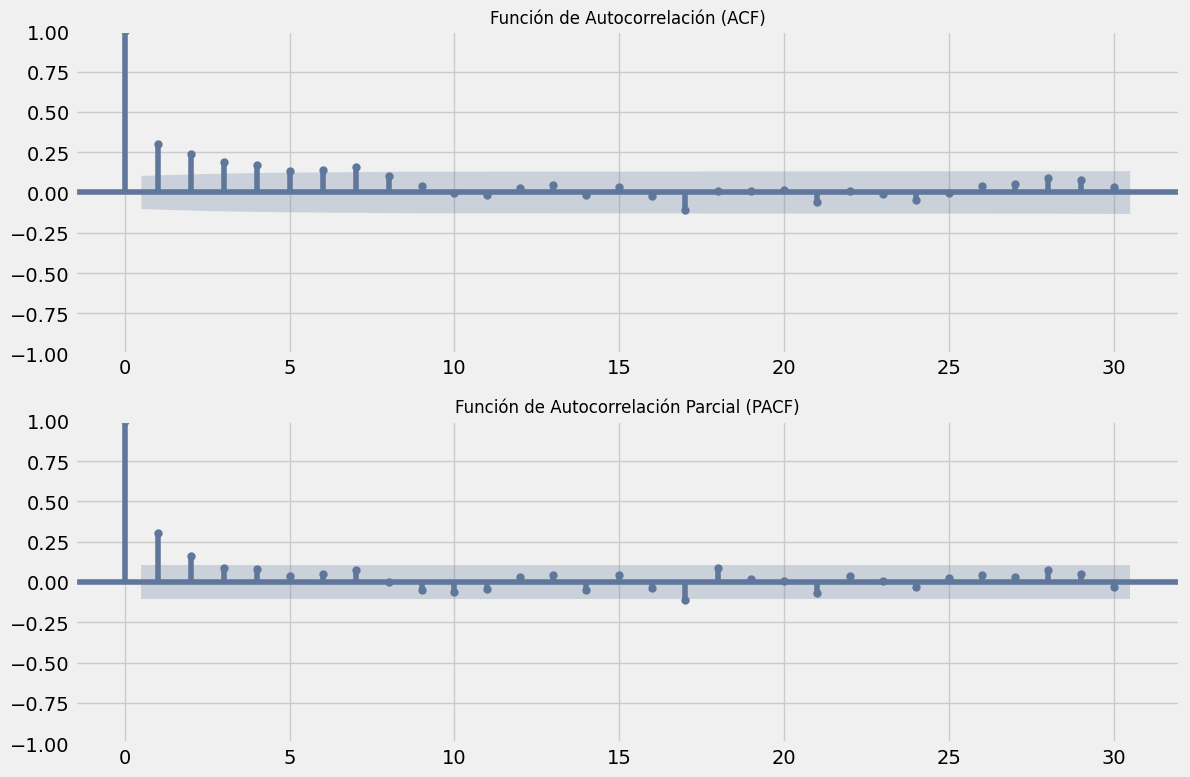

In [35]:
# Gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Crear figura
plt.figure(figsize=(12, 8))

# ACF
plt.subplot(2, 1, 1)
plot_acf(y_s1['pdq'], lags=30, ax=plt.gca())
plt.title("Función de Autocorrelación (ACF)", fontsize=12)

# PACF
plt.subplot(2, 1, 2)
plot_pacf(y_s1['pdq'], lags=30, ax=plt.gca())
plt.title("Función de Autocorrelación Parcial (PACF)", fontsize=12)

plt.tight_layout()
plt.show()

Parece que esta es una serie estacionaria, pues los gráficos ACF y PACF muestran una disminución rápida de las correlaciones después de pocos retardos. Verifiquemos si esto es válido mediante la prueba de Dickey-Fuller.

In [36]:
# Prueba de Dickey-Fuller para verificar estacionariedad
from statsmodels.tsa.stattools import adfuller
import pandas as pd

print("📊 Resultados de la prueba de Dickey-Fuller:")

# Ejecutar el test
resultado = adfuller(y_s1['pdq'], autolag='AIC')

# Organizar resultados principales
df_output = pd.Series(resultado[0:4],
                      index=['Estadístico de prueba', 'Valor p', '# de retardos usados', 'Número de observaciones'])

# Mostrar resultados
print(df_output)

# Interpretación rápida
if resultado[1] <= 0.05:
    print("\n✅ Se rechaza la hipótesis nula: la serie es estacionaria.")
else:
    print("\n❌ No se rechaza la hipótesis nula: la serie no es estacionaria.")

📊 Resultados de la prueba de Dickey-Fuller:
Estadístico de prueba     -6.546213e+00
Valor p                    9.085797e-09
# de retardos usados       3.000000e+00
Número de observaciones    3.570000e+02
dtype: float64

✅ Se rechaza la hipótesis nula: la serie es estacionaria.


Como esta serie verificamos que es estacionaria mediante estas pruebas, podemos ajustar un modelo SARIMA a esta serie.

In [37]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

In [38]:
# iterar para los distintos escenarios

frames = []
for param in params:
    try:
        sarima_model = SarimaModels(param)
        df_metrics = sarima_model.metrics(y_s1,target_date)
        frames.append(df_metrics)
    except:
        pass

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [39]:
# juntar resultados de las métricas y comparar
df_metrics_result = pd.concat(frames)
df_metrics_result.sort_values(['mae','mape'])

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,1.5876,3.4224,1.8500,0.0622,0.0620,0.0614,0.0599,0.0614,"SARIMA_(0,0,0)X(1,0,1,12)"
0,1.5934,3.4304,1.8521,0.0624,0.0622,0.0616,0.0600,0.0616,"SARIMA_(0,0,1)X(1,0,1,12)"
0,1.6021,3.4537,1.8584,0.0627,0.0625,0.0619,0.0603,0.0619,"SARIMA_(1,0,0)X(1,0,1,12)"
0,1.6444,3.7832,1.9451,0.0654,0.0651,0.0635,0.0629,0.0635,"SARIMA_(0,0,0)X(0,1,1,12)"
0,1.6444,3.7833,1.9451,0.0654,0.0651,0.0635,0.0629,0.0635,"SARIMA_(0,0,0)X(1,1,1,12)"
...,...,...,...,...,...,...,...,...,...
0,7.8111,73.7850,8.5898,0.2988,0.2862,0.3019,0.2877,0.3654,"SARIMA_(1,1,0)X(0,1,0,12)"
0,22.8403,550.3448,23.4594,0.8845,0.7122,0.8827,0.8514,1.6822,"SARIMA_(0,0,1)X(0,0,1,12)"
0,23.0209,560.5370,23.6757,0.8899,0.7147,0.8896,0.8567,1.7030,"SARIMA_(0,0,0)X(0,0,1,12)"
0,25.5633,660.3857,25.6980,0.9886,0.7779,0.9879,0.9517,1.9706,"SARIMA_(0,0,1)X(0,0,0,12)"


En este caso, el mejor desempeño lo obtiene el modelo $SARIMA(0,0,0)\times(1,0,1,12)$, pues de los modelos probados es el que tiene en general las métricas de error más pequeñas. Veamos en el siguiente gráfico cómo se ajusta este modelo a los datos observados.

In [40]:
# Ajustar mejor modelo (manteniendo tu interfaz)

param = [(0,0,0),(1,0,1,12)]
sarima_model =  SarimaModels(param)
model_fit = sarima_model.fit_model(y_s1,target_date)
best_model = sarima_model.df_testig(y_s1,target_date)
best_model.head()

,y,yhat
2021-01-03,27.622449,26.158300
2021-01-10,27.425532,25.926904
2021-01-17,27.235294,26.083722
2021-01-24,24.012658,26.308889
2021-01-31,27.716418,26.074933


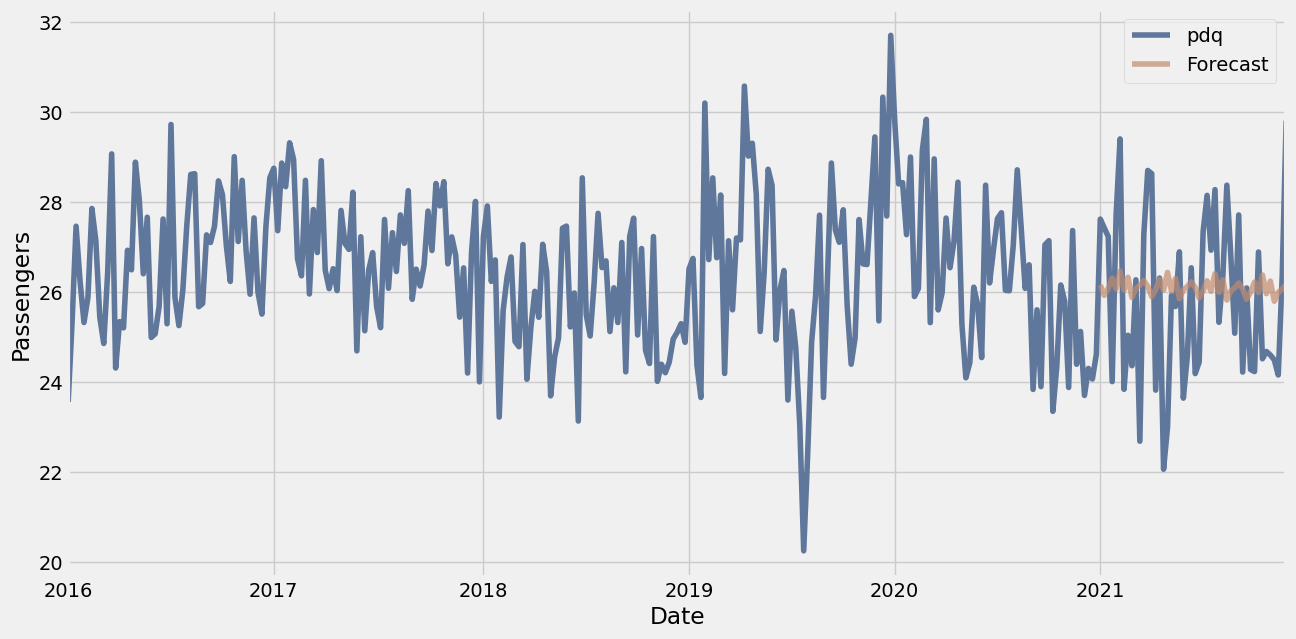

In [41]:
# Graficar el mejor modelo

# Se extraen las predicciones del modelo ajustado
preds = best_model['yhat']

# Se grafica la serie original desde 1949 en adelante
ax = y_s1['2016':].plot(label='observed')

# Se superponen las predicciones sobre la misma figura
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))

# Se agregan etiquetas a los ejes
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')

# Se muestra la leyenda y el gráfico final
plt.legend()
plt.show()

Podemos ver que el mejor modelo encontrado parece estar bastante cercano de la media de los valores tomados en la serie temporal, con ruido de bastante menor magnitud que el presente en la serie. Veamos los errores de este modelo para verificar que tan buen predictor es.

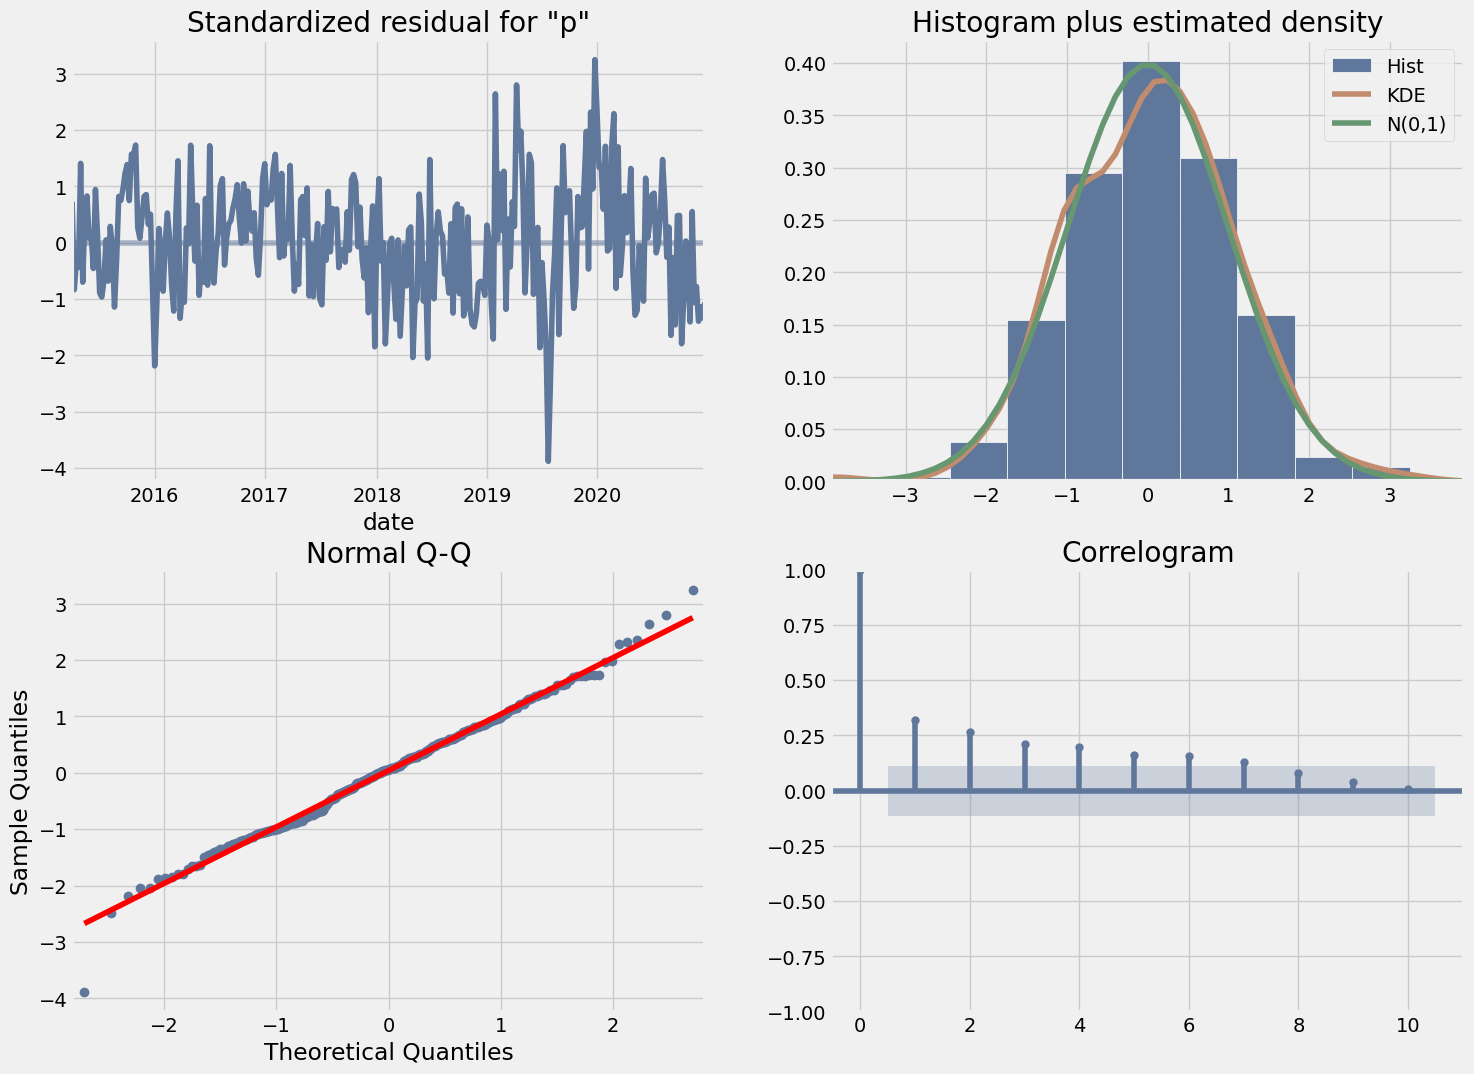

In [42]:
# Evaluar los errores del modelo
# La función plot_diagnostics muestra cuatro gráficos que permiten analizar los residuales
model_fit.plot_diagnostics(figsize=(16, 12))
plt.show()

Veamos gráfico por gráfico:

1. El residual estandarizado no presenta patrones obvios y fluctúan alrededor de cero. Luego, el modelo capturó bien la estructura temporal.
2. El histograma y densidad parecen calzar bastante bien con la distribución normal. Las curvas KDE y N(0,1) se superponen bastante bien, luego los errores son aproximadamente normales.
3. El gráfico Q-Q muestra que los valores están bastante cercanos a la linea roja, luego los residuales siguen una distribución normal.
4. El correlograma presenta unas cuantas barras fuera del intervalo de confianza, lo que significa que hay una parte de la estructura temporal que no logró modelar bien.

Lo anterior se resume en que este modelo, aunque logró hacer que los errores de la serie fuesen normales, no logró predecir bien el patrón observado. Esto se ve claramente por la diferencia de magnitud de los errores de la serie temporal predecida versus observada.




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


Hagamos lo mismo pero ahora con la librería `Prophet`.

In [43]:
# Definir fecha objetivo para dividir los datos
target_date = '2021-01-01'

# Crear conjuntos de entrenamiento y prueba
y_train = y_s1.loc[y_s1.index < target_date]
y_test  = y_s1.loc[y_s1.index >= target_date]

# rename
y_train_prophet = y_train.reset_index()
y_train_prophet.columns = ["ds","y"]

y_test_prophet = y_test.reset_index()
y_test_prophet.columns = ["ds","y"]


In [44]:
from prophet import Prophet

# model
m = Prophet()
m.fit(y_train_prophet)

# forecast
future = m.make_future_dataframe(periods=365*4)
forecast = m.predict(future)[['ds', 'yhat']]
forecast.tail()

AttributeError: 'Prophet' object has no attribute 'stan_backend'

Intenté arreglar esto durante la semana pero no pude arreglarlo. Creo que tiene que ver con algún comando desactualizado dentro de la librería o que se actualizó algo que no permite llamar al modelo Prophet de la forma mostrada en la clase. Intenté también arreglarlo con IA pero también me tira el mismo error :C